# Stellar Scout: Exploritory Data Analysis
This is the first script that should be run for our project. In this file we will load in data from our sources, combine them, explore the data, clean out missing values and outliers, construct some features, peform feature reduction, scale the data, and save it to a file for models to use. Each step will explain our methodology step by step and there are parameters in the second code cell to adjust which steps to run.

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_rows', 500)

## User Parameters
You can use these parameters to adjust the data generated by this script. Each parameter has a comment describing what it will do or toggle.

In [226]:
file_location = "data/" # Location of data
drop_outliers = False # True if you want to drop outliers
drop_redundant = True # True if you want to drop variables deemed redundant
pca = True # True if you want to apply Principal Component Analysis
standard_scalar = True # True if you want to use standard scalar, False if you want to use min-max normalization

## Merging the Datasets
The first step, is to load in our data. We have two datasets, the K2 Planets and Candidates and the Cumulative Kepler Data files from NASA's archive. After they are loaded in we need to combine the columns that notate the same data but have different names.

In [227]:
# Read in data
k2_df = pd.read_csv(file_location + "K2_2024.06.06_20.23.11.csv", comment='#')
kep_df = pd.read_csv(file_location + "KOI_2024.06.06_20.22.41.csv", comment='#')

In [228]:
# Inspect K2 data
print(k2_df.shape)
print(k2_df["disposition"].value_counts())

(3839, 16)
disposition
CONFIRMED         2156
CANDIDATE         1372
FALSE POSITIVE     293
REFUTED             18
Name: count, dtype: int64


In [229]:
# Looking at data types and for null values
k2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pl_name      3839 non-null   object 
 1   hostname     3839 non-null   object 
 2   disposition  3839 non-null   object 
 3   pl_orbper    3800 non-null   float64
 4   pl_orbsmax   777 non-null    float64
 5   pl_rade      3030 non-null   float64
 6   pl_insol     519 non-null    float64
 7   pl_eqt       709 non-null    float64
 8   pl_trandur   2718 non-null   float64
 9   st_teff      2731 non-null   float64
 10  st_rad       3715 non-null   float64
 11  st_mass      1968 non-null   float64
 12  st_met       1568 non-null   float64
 13  st_logg      2204 non-null   float64
 14  sy_dist      3716 non-null   float64
 15  sy_kepmag    3824 non-null   float64
dtypes: float64(13), object(3)
memory usage: 480.0+ KB


In [230]:
# Inspect Kepler data
print(kep_df.shape)
print(kep_df["koi_disposition"].value_counts())

(9564, 16)
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2743
CANDIDATE         1982
Name: count, dtype: int64


In [231]:
# Looking at data types and for null values
kep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepid            9564 non-null   int64  
 1   kepoi_name       9564 non-null   object 
 2   kepler_name      2745 non-null   object 
 3   koi_disposition  9564 non-null   object 
 4   koi_period       9564 non-null   float64
 5   koi_duration     9564 non-null   float64
 6   koi_prad         9201 non-null   float64
 7   koi_sma          9201 non-null   float64
 8   koi_teq          9201 non-null   float64
 9   koi_insol        9243 non-null   float64
 10  koi_steff        9201 non-null   float64
 11  koi_slogg        9201 non-null   float64
 12  koi_smet         9178 non-null   float64
 13  koi_srad         9201 non-null   float64
 14  koi_smass        9201 non-null   float64
 15  koi_kepmag       9563 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 1.2+ MB


In [232]:
# Map K2 column names to Kepler column names
column_mapping = {
    #'pl_name': 'kepler_name', # probably not useful
    'disposition': 'koi_disposition', # target, status of the object
    'pl_orbper': 'koi_period', # orbital period
	'pl_orbsmax': 'koi_sma', # semi-major axis
    'pl_rade': 'koi_prad', # planet radius
    'pl_trandur': 'koi_duration', # transit duration
    'pl_insol': 'koi_insol', # insolation flux
    'pl_eqt': 'koi_teq', # equilibrium temperature
    'sy_kepmag': 'koi_kepmag', # Kepler magnitude
    'st_rad': 'koi_srad', # stellar radius
    'st_teff': 'koi_steff', # stellar effective temperature
    'st_logg': 'koi_slogg', # stellar surface gravity
	'st_mass': 'koi_smass', # stellar mass
	'st_met': 'koi_smet', # stellar metallicity
}

# Declare new column names
new_column_names = {
    #'pl_name': 'planet_name',
    'disposition': 'status',
    'pl_orbper': 'orbital_period',
    'pl_orbsmax': 'semi_major_axis',
    'pl_rade': 'planet_radius',
    'pl_trandur': 'transit_duration',
    'pl_insol': 'insolation_flux',
    'pl_eqt': 'equilibrium_temperature',
    'sy_kepmag': 'kepler_magnitude',
    'st_rad': 'stellar_radius',
    'st_teff': 'stellar_effective_temperature',
    'st_logg': 'stellar_surface_gravity',
    'st_mass': 'stellar_mass',
    'st_met': 'stellar_metallicity'
}

In [233]:
# Columns from k2_df
k2_columns = list(column_mapping.keys())
k2_df_selected = k2_df[k2_columns]
print(k2_df_selected.shape)
k2_df_selected.head(3)

(3839, 13)


,disposition,pl_orbper,pl_orbsmax,pl_rade,pl_trandur,pl_insol,pl_eqt,sy_kepmag,st_rad,st_teff,st_logg,st_mass,st_met
0,CONFIRMED,0.759976,NaN,12.547,0.974735,9668.66,2529.0,12.310,1.66,5690.2,4.00,NaN,NaN
1,CANDIDATE,1.152400,0.0125,0.675,NaN,8270.03,NaN,12.302,1.06,5992.0,4.39,0.99,-0.095
2,CONFIRMED,0.719571,NaN,1.611,1.757522,6635.86,2302.0,9.438,1.26,5910.0,4.27,NaN,NaN


In [234]:
# Columns from kep_df
kep_columns = list(column_mapping.values())
kep_df_selected = kep_df[kep_columns]
print(kep_df_selected.shape)
kep_df_selected.head(3)

(9564, 13)


,koi_disposition,koi_period,koi_sma,koi_prad,koi_duration,koi_insol,koi_teq,koi_kepmag,koi_srad,koi_steff,koi_slogg,koi_smass,koi_smet
0,CONFIRMED,9.488036,0.0853,2.26,2.9575,93.59,793.0,15.347,0.927,5455.0,4.467,0.919,0.14
1,CONFIRMED,54.418383,0.2734,2.83,4.5070,9.11,443.0,15.347,0.927,5455.0,4.467,0.919,0.14
2,CANDIDATE,19.899140,0.1419,14.60,1.7822,39.30,638.0,15.436,0.868,5853.0,4.544,0.961,-0.18


In [235]:
# Rename columns in Kepler dataframe
kep_df_selected.columns = k2_df_selected.columns

# Combine the two dataframes
combined_df = pd.concat([k2_df_selected, kep_df_selected], axis=0, ignore_index=True)
combined_df = combined_df.rename(columns=new_column_names)

# Inspect combined dataframe
print(combined_df.shape)
combined_df.head(3)

(13403, 13)


,status,orbital_period,semi_major_axis,planet_radius,transit_duration,insolation_flux,equilibrium_temperature,kepler_magnitude,stellar_radius,stellar_effective_temperature,stellar_surface_gravity,stellar_mass,stellar_metallicity
0,CONFIRMED,0.759976,NaN,12.547,0.974735,9668.66,2529.0,12.310,1.66,5690.2,4.00,NaN,NaN
1,CANDIDATE,1.152400,0.0125,0.675,NaN,8270.03,NaN,12.302,1.06,5992.0,4.39,0.99,-0.095
2,CONFIRMED,0.719571,NaN,1.611,1.757522,6635.86,2302.0,9.438,1.26,5910.0,4.27,NaN,NaN


## Cleaning the Data
Now that we finally have our dataset we need to prepare our target variable for our models by setting it to 1 or 0 instead of the categorical that it is currently. We also need to deal with the missing values and remove outliers if desired.

In [236]:
# Look at distribution of target values
disposition_counts = combined_df['status'].value_counts()
print(disposition_counts)

status
FALSE POSITIVE    5132
CONFIRMED         4899
CANDIDATE         3354
REFUTED             18
Name: count, dtype: int64


In [237]:
# Get rid of 'CANDIDATE' and switch to boolean
df = combined_df[combined_df['status'] != 'CANDIDATE']
df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})

# Look at distribution of target values
disposition_counts = df['status'].value_counts()
print(disposition_counts)

status
0    5150
1    4899
Name: count, dtype: int64


C:\Users\Ethan\AppData\Local\Temp\ipykernel_272\2732489177.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})
C:\Users\Ethan\AppData\Local\Temp\ipykernel_272\2732489177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})


In [238]:
# Count null values
null_counts = df.isnull().sum()
print(null_counts)

status                              0
orbital_period                     19
semi_major_axis                  1981
planet_radius                     800
transit_duration                  916
insolation_flux                  2219
equilibrium_temperature          2100
kepler_magnitude                    8
stellar_radius                    353
stellar_effective_temperature     784
stellar_surface_gravity          1131
stellar_mass                     1128
stellar_metallicity              1517
dtype: int64


In [239]:
# Drop rows with null values
df = df.dropna()

# Get rid of outliers
if drop_outliers:
	# Calculate the z-score for each column
	threshold = 3
	outliers = np.full(df.shape[0], False)
	for column in df.columns:
		if column == "status":
			continue
		z = np.abs(stats.zscore(df[column]))

		# Identify outliers as students with a z-score greater than 3
		outliers = (z > threshold) | outliers

	# Print and remove the outliers
	df = df[~outliers]
	print(f"Number of outliers: {len(np.where(outliers)[0])}")

# Look at distribution of target values
disposition_counts = df['status'].value_counts()
print(disposition_counts)

status
0    4561
1    2825
Name: count, dtype: int64


In [240]:
# Check for missing values and data types and inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7386 entries, 8 to 13402
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   status                         7386 non-null   int64  
 1   orbital_period                 7386 non-null   float64
 2   semi_major_axis                7386 non-null   float64
 3   planet_radius                  7386 non-null   float64
 4   transit_duration               7386 non-null   float64
 5   insolation_flux                7386 non-null   float64
 6   equilibrium_temperature        7386 non-null   float64
 7   kepler_magnitude               7386 non-null   float64
 8   stellar_radius                 7386 non-null   float64
 9   stellar_effective_temperature  7386 non-null   float64
 10  stellar_surface_gravity        7386 non-null   float64
 11  stellar_mass                   7386 non-null   float64
 12  stellar_metallicity            7386 non-null   float

In [241]:
# Make sure dataframe looks good
df.head()

,status,orbital_period,semi_major_axis,planet_radius,transit_duration,insolation_flux,equilibrium_temperature,kepler_magnitude,stellar_radius,stellar_effective_temperature,stellar_surface_gravity,stellar_mass,stellar_metallicity
8,1,0.571336,0.01312,1.820,1.79000,4293.0,2063.0,11.958,0.95,5496.0,4.42,0.92,0.060
22,1,2.180535,0.03558,16.197,2.92780,1860.0,1828.0,11.468,1.26,6360.0,4.34,1.26,0.137
37,1,3.595100,0.04700,1.950,4.33000,1037.0,1616.0,11.364,1.71,5430.0,3.99,1.05,0.200
39,1,1.673902,0.04220,3.450,1.60560,990.0,1094.0,10.408,1.19,6120.0,4.36,1.18,0.140
45,1,0.658524,0.01306,3.300,0.33336,879.5,1515.0,11.386,0.70,4285.0,4.58,0.69,-0.120


Great now that our data is cleaned and prepared, lets see if we can make some new features!

## Feature Engineering

### Astronomical Features
Given the data we have, there are some calculations we can perform to create some new features for the models to work with. 
- Transit Depth: Refers to the fraction of a star's light that is blocked by a planet as it passes in front of the star, as seen from the satellite. The transit depth is another way of thinking about the size of the planet relative to its host star.

In [242]:
# Transit Depth
re = 6.371e6 # Radius of the Earth in km
rs = 6.96340e8 # Radius of the Sun in km
df["transit_depth"] = ((df["planet_radius"]*re) / (df["stellar_radius"]*rs)) ** 2

#Get and display the correlations
correlations = df.corr()["status"].sort_values(ascending = False)
print('Correlations:\n', correlations)

Correlations:
 status                           1.000000
stellar_metallicity              0.331551
stellar_surface_gravity          0.186874
kepler_magnitude                 0.028352
planet_radius                   -0.024708
transit_depth                   -0.028004
insolation_flux                 -0.039325
stellar_radius                  -0.088831
semi_major_axis                 -0.119800
orbital_period                  -0.141338
transit_duration                -0.171596
stellar_mass                    -0.197486
stellar_effective_temperature   -0.231947
equilibrium_temperature         -0.280825
Name: status, dtype: float64


### Log Transformations

Some data may benefit from a log transformation. We are going to see if we can determine the best choices for these variables by testing the correlation of the original vs the log transformed version. If the log transformed version shows a higher correlation, we will use it

In [243]:
# Identify variables that should use log transformation (based on correlation)
log_df = df.copy()
for column in log_df.columns:
	if min(log_df[column]) > 0:
		log_df[column + "_log"] = np.log(log_df[column])

# Get the correlations with the log transformation
correlations = log_df.corr()["status"].sort_values(ascending = False)

# If the correlation is greater than the correlation of the variable without the log transformation, use the log transformation
print("Columns Using Log Transformation:")
for column in log_df.columns:
	if "_log" in column:
		if np.abs(correlations[column]) > np.abs(correlations[column[0:-4]]):
			print("     " + column[0:-4])
			df[column] = log_df[column]
			df.drop(column[0:-4], axis=1, inplace=True) # Drop the original variable without the log

# Get and display the correlations
correlations = df.corr()["status"].sort_values(ascending = False)
print('\nCorrelations:\n', correlations)


Columns Using Log Transformation:
     planet_radius
     insolation_flux
     kepler_magnitude
     stellar_radius
     transit_depth

Correlations:
 status                           1.000000
stellar_metallicity              0.331551
stellar_surface_gravity          0.186874
kepler_magnitude_log             0.033003
semi_major_axis                 -0.119800
orbital_period                  -0.141338
transit_duration                -0.171596
stellar_mass                    -0.197486
stellar_radius_log              -0.199897
insolation_flux_log             -0.221799
stellar_effective_temperature   -0.231947
equilibrium_temperature         -0.280825
transit_depth_log               -0.345583
planet_radius_log               -0.394207
Name: status, dtype: float64


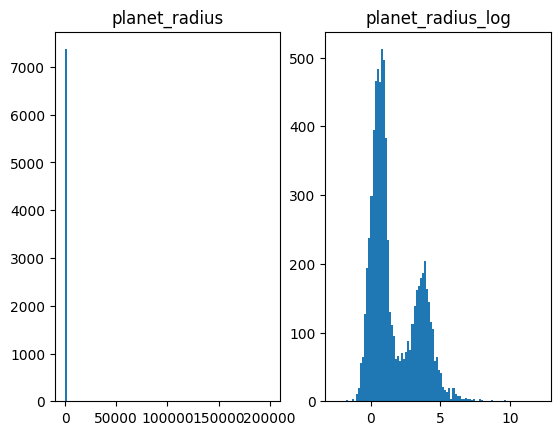

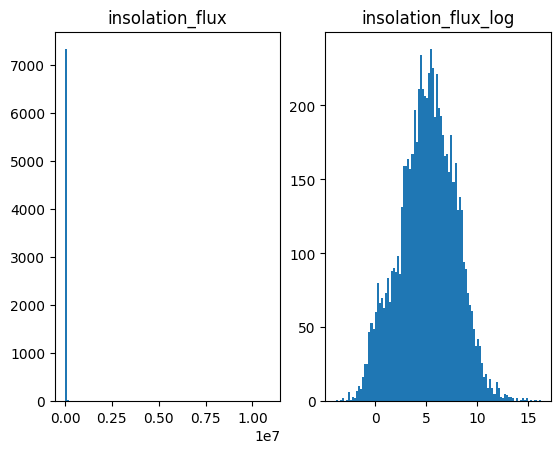

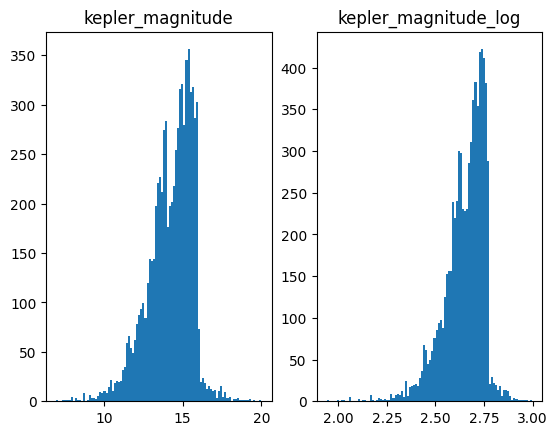

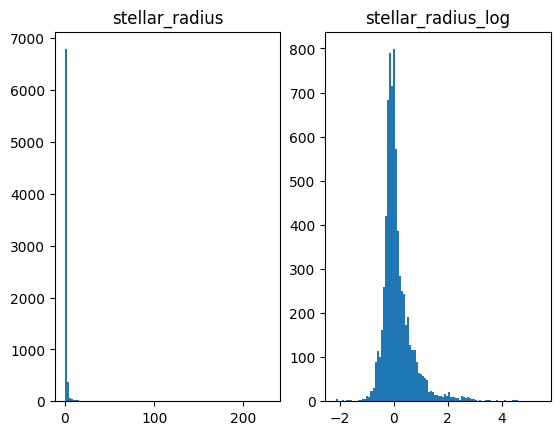

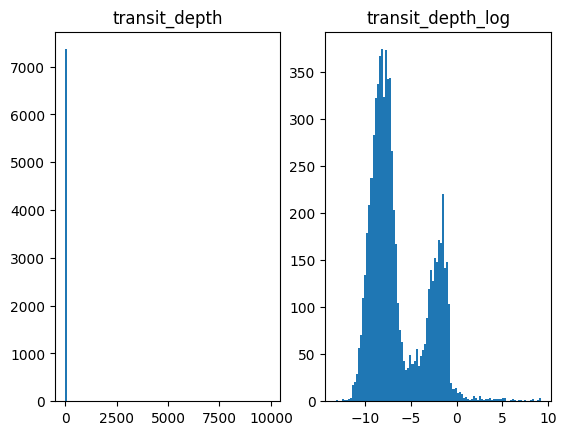

In [244]:
bins = 100
for column in df:
	if "_log" in column:
		plt.figure()

		# Plot histogram of original variable
		plt.subplot(1,2,1)
		plt.title(column[0:-4])
		plt.hist(log_df[column[0:-4]], bins=bins)

		# Plot histogram of log transformed variable
		plt.subplot(1,2,2)
		plt.title(column)
		plt.hist(log_df[column], bins=bins)

		plt.show()


For the most part we can see that the transformations identified were definitely a good decision. It has made the distributions much easier to work with.

## Dimensionality Reduction

### Feature Redundancy
One of the first and somewhat easiest steps is to simply drop features that encode the same data. There is some subject matter expertise that can assist with this, for instance, knowing that the orbital period and semi-major axis features are derived from each other. That being said, it would be better to determine this a bit more empirically. Instead, lets compare the correlation between each feature with each other and note the ones that exceed 0.8 which would make them highly correlated which means they likely encode the same information.

In [245]:
factor = 0.8
correlations = df.corr()
for column in correlations.columns:
	if column == "status":
		continue

	# Drop status and and up to current column
	correlation_values = correlations[column].drop(index=["status", column])

	# Check if correlation is greater than 0.8
	correlated = np.abs(correlation_values) > factor
	correlated_columns = correlated[correlated == True].index.to_list()
	print(column + ": " + str(correlated_columns), str(correlation_values[correlated_columns].values))


orbital_period: ['semi_major_axis'] [0.95951458]
semi_major_axis: ['orbital_period'] [0.95951458]
transit_duration: [] []
equilibrium_temperature: ['insolation_flux_log'] [0.86891899]
stellar_effective_temperature: [] []
stellar_surface_gravity: ['stellar_radius_log'] [-0.98111308]
stellar_mass: [] []
stellar_metallicity: [] []
planet_radius_log: ['transit_depth_log'] [0.9310719]
insolation_flux_log: ['equilibrium_temperature'] [0.86891899]
kepler_magnitude_log: [] []
stellar_radius_log: ['stellar_surface_gravity'] [-0.98111308]
transit_depth_log: ['planet_radius_log'] [0.9310719]


This methodology seems to work since orbital period and semi-major axis are showing as highly correlated with one another. The only reason they are not 1:1 is probably because some of the orbits are not assumed to be circular which starts to break the linearity present in most cases. Lets remove the features that are correlated with others by preferring to remove the features that are less correlated with the target.

In [246]:
# Removing Redundant Variables
if drop_outliers and drop_redundant:
	df = df.drop(["semi_major_axis", "stellar_surface_gravity", "orbital_period_log", "semi_major_axis_log", "insolation_flux_log", "stellar_surface_gravity_log", "transit_depth_log"], axis=1)
elif not drop_outliers and drop_redundant:
	df = df.drop(["semi_major_axis", "stellar_surface_gravity", "insolation_flux_log", "kepler_magnitude_log", "transit_depth_log"], axis=1)

Lets double check that it worked correctly. There should be no correlations above 0.8 present now.

In [247]:
correlations = df.corr()
for column in correlations.columns:
	if column == "status":
		continue

	# Drop status and and up to current column
	correlation_values = correlations[column].drop(index=["status", column])

	# Check if correlation is greater than 0.8
	correlated = np.abs(correlation_values) > factor
	correlated_columns = correlated[correlated == True].index.to_list()
	print(column + ": " + str(correlated_columns), str(correlation_values[correlated_columns].values))

orbital_period: [] []
transit_duration: [] []
equilibrium_temperature: [] []
stellar_effective_temperature: [] []
stellar_mass: [] []
stellar_metallicity: [] []
planet_radius_log: [] []
stellar_radius_log: [] []


Great, everything seems to be working as intended, now lets see if we can use PCA to remove some more features.

### PCA
Something interesting we can try in using Principle Component Analysis to reduce the number of features. Through some testing, we found that combining these three stellar variables into 2 components ended up producing new features that were more correlated than the original features. So if desired, you can turn PCA on and drop one feature from the set. PCA didn't seem to help much in other cases that we tried unfortunately.

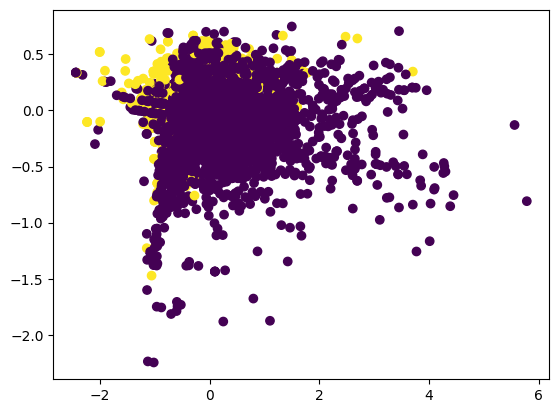

In [248]:
if pca:
	# Stellar Parameters PCA (Found this to be the most useful combination)
	stellar_pca = df[["stellar_mass", "stellar_metallicity", "stellar_radius_log"]]
	principal=PCA(n_components=2)
	principal.fit(stellar_pca)
	stellar_pca=principal.transform(stellar_pca)

	# Add PCA components to dataframe
	for i in range(stellar_pca.shape[1]):
		df["stellar_pca" + str(i+1)] = stellar_pca[:,i]

	df = df.drop(["stellar_mass", "stellar_metallicity", "stellar_radius_log"], axis=1)

	# Plot the new data
	plt.figure()
	plt.scatter(stellar_pca[:,0], stellar_pca[:,1], c=df["status"])

Lets take one last look at the correlations to see how things have changed.

In [249]:
# Get and display the correlations
correlations = df.corr()["status"].sort_values(ascending = False)
print('Correlations:\n', correlations)

Correlations:
 status                           1.000000
stellar_pca2                     0.341834
orbital_period                  -0.141338
transit_duration                -0.171596
stellar_pca1                    -0.196819
stellar_effective_temperature   -0.231947
equilibrium_temperature         -0.280825
planet_radius_log               -0.394207
Name: status, dtype: float64


Our second PCA parameter is now the highest correlated feature! Now lets scale the data and send it off to the models.

## Scaling
All the algorithms we are testing will benefit from the data being scaled with the standard scalar. This will bring the mean of each feature very close to 0 and scale by the standard deviation. Many models perform much better with this data as it is easier when each feature contributes equally rather than for instance a neural network needing to scale the weights just to get things in check.

In [250]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop("status", axis=1))
scaled_df = pd.DataFrame(scaled_data, columns = df.drop("status", axis=1).columns)
scaled_df.insert(0, 'status', np.array(df['status']))

In [251]:
scaled_df.describe()

,status,orbital_period,transit_duration,equilibrium_temperature,stellar_effective_temperature,planet_radius_log,stellar_pca1,stellar_pca2
count,7386.000000,7.386000e+03,7.386000e+03,7.386000e+03,7.386000e+03,7386.000000,7.386000e+03,7.386000e+03
mean,0.382480,3.078441e-17,-3.078441e-17,-4.617662e-17,5.079428e-16,0.000000,-3.078441e-17,-3.078441e-17
std,0.486026,1.000068e+00,1.000068e+00,1.000068e+00,1.000068e+00,1.000068,1.000068e+00,1.000068e+00
min,0.000000,-4.203410e-01,-8.200984e-01,-1.183644e+00,-3.706335e+00,-2.489831,-3.590020e+00,-7.880831e+00
25%,0.000000,-4.033622e-01,-4.715822e-01,-6.361334e-01,-4.941413e-01,-0.738336,-5.205449e-01,-4.848037e-01
50%,0.000000,-3.565505e-01,-2.731047e-01,-2.450544e-01,7.214401e-02,-0.409800,-1.853702e-01,1.392168e-01
75%,1.000000,-1.893453e-01,7.758107e-02,3.627941e-01,4.930564e-01,0.905751,2.627410e-01,6.617377e-01
max,1.000000,3.063117e+01,1.943912e+01,1.510200e+01,1.239417e+01,6.294075,8.505346e+00,2.623328e+00


## Saving the data
The data will now be saved off to a csv to be imported by each of our models.

In [252]:
# Saving the dataframe
scaled_df.to_csv(file_location + "final_data.csv", index=False)